In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecNormalize
import torch
import numpy as np
import matplotlib.pyplot as plt
from minigrid.wrappers import ImgObsWrapper
from IPython.display import display

# from sb3_ppo import make_ppo_agent
from envs.custom_fourrooms import FourRoomsEnv17, FourRoomsEnv15, FourRoomsEnv13, FourRoomsEnv11, FourRoomsEnv09
from evaluation.evaluation import capture_frames_sb3, count_parameters
from evaluation.visualization import create_animation
from wrappers import BaseWrapper, RandomRotateWrapper, Rotate90Wrapper, Rotate180Wrapper, Rotate270Wrapper
from models.features_extractor import MinigridFeaturesExtractor, SmallKernelC4EquivariantCNN

from tensorboard import notebook

In [2]:
# Configuration
ENV_NAME = FourRoomsEnv09#'MiniGrid-FourRooms-v0'

# Training parameters
TIMESTEPS = 1e6

# Evaluation parameters
NUM_EVAL_EPISODES = 10
RENDER_EVALUATION = True

# TensorBoard log directory
TENSORBOARD_LOG_DIR = "./tensorboard_logs/"

# Set random seeds for reproducibility
SEED = 5
torch.manual_seed(SEED)
np.random.seed(SEED)

## 1. Setting Up the Environment

We'll use the MiniGrid environment wrapped with ImgObsWrapper to provide image observations.

In [3]:
def make_ppo_agent(env, use_equivariant_cnn, seed, config=None, load=None, tensorboard_log=None, device='auto'):
    if config is None:
        config = {}
        
    if use_equivariant_cnn:
        policy_kwargs = dict(
            features_extractor_class=SmallKernelC4EquivariantCNN,
            features_extractor_kwargs=dict(features_dim=256),
            normalize_images=False,
        )
    else:
        policy_kwargs = dict(
            features_extractor_class=MinigridFeaturesExtractor,
            features_extractor_kwargs=dict(features_dim=256),
            normalize_images=False,
        )
    
    if 'policy_kwargs' in config:
        policy_kwargs.update(config.pop('policy_kwargs'))
    
    if load is not None:
        print('Loading model from', load)
        model = PPO.load(load, env=env, policy_kwargs=policy_kwargs, seed=seed, verbose=1, device=device, tensorboard_log=tensorboard_log, **config)
    else:
        model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, seed=seed, verbose=1, device=device, tensorboard_log=tensorboard_log, **config)
    return model

In [4]:
NUM_ENVS = 32
FULL_OBS = True
base_wrapper_kwargs = {'full_obs': FULL_OBS}
aug_wrapper_kwargs = {'full_obs': FULL_OBS, 'subset': [0,1]}
std_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=BaseWrapper,
                               wrapper_kwargs=base_wrapper_kwargs,
                               monitor_dir='./logs/std')
# std_vec_env = VecNormalize(std_vec_env, norm_obs=False, norm_reward=True)

aug_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=RandomRotateWrapper,
                               wrapper_kwargs=aug_wrapper_kwargs,
                               monitor_dir='./logs/aug')
# aug_vec_env = VecNormalize(aug_vec_env, norm_obs=False, norm_reward=True)

eq_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=BaseWrapper,
                               wrapper_kwargs=base_wrapper_kwargs,
                               monitor_dir='./logs/eq')
# eq_vec_env = VecNormalize(eq_vec_env, norm_obs=False, norm_reward=True)

aug_eq_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=RandomRotateWrapper,
                               wrapper_kwargs=aug_wrapper_kwargs,
                               monitor_dir='./logs/aug_eq')
# aug_eq_vec_env = VecNormalize(aug_eq_vec_env, norm_obs=False, norm_reward=True)

In [5]:
def make_starting_env(env_name):
    if env_name == "MiniGrid-FourRooms-v0":
        env = gym.make(env_name, render_mode="rgb_array")
    else:
        env = env_name(render_mode="rgb_array")
    return env

def make_eval_env(wrapper_class=None, subset=None, full_obs=FULL_OBS):
    env = make_starting_env(env_name=ENV_NAME)
    if wrapper_class is None:
        env = BaseWrapper(env, full_obs=full_obs)
    else:
        if subset is None:
            env = wrapper_class(env, full_obs=full_obs)
        else:
            env = wrapper_class(env, subset, full_obs=full_obs)
    env = Monitor(env)
    return env

In [6]:
eval_env = make_eval_env()
eval_90_env = make_eval_env(Rotate90Wrapper)
eval_180_env = make_eval_env(Rotate180Wrapper)
eval_270_env = make_eval_env(Rotate270Wrapper)
eval_rand_env = make_eval_env(RandomRotateWrapper, subset=[0, 1, 2, 3])
eval_0_90_env = make_eval_env(RandomRotateWrapper, subset=[0, 1])
eval_180_270_env = make_eval_env(RandomRotateWrapper, subset=[2, 3])

print(f"Environment: {ENV_NAME}")
print(f"Observation shape: {eval_env.observation_space.shape}")
print(f"Action space: {eval_env.action_space}")

Environment: <class 'envs.custom_fourrooms.FourRoomsEnv09'>
Observation shape: (9, 9, 3)
Action space: Discrete(3)


## 2. PPO Default Hyperparameters

Below are the default hyperparameters for PPO that can be configured:

In [7]:
n_steps = 64
num_minibatches = 8
batch_size = int(n_steps * NUM_ENVS / num_minibatches)
print(f'Batch size: {batch_size}')
default_ppo_params = {
    "learning_rate": 3e-4,
    "n_steps": n_steps,
    "batch_size": batch_size,
    "n_epochs": 4,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "clip_range_vf": None,
    "normalize_advantage": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
}

def lr_schedule(starting_lr=3e-4):
    def scheduler(progress_remaining):
        return max(starting_lr * progress_remaining, 1e-4)
    return scheduler

# default_ppo_params["learning_rate"] = lr_schedule(default_ppo_params["learning_rate"])

standard_config = default_ppo_params.copy()
equivariant_config = default_ppo_params.copy()

Batch size: 256


## 3. Training Agents

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Start TensorBoard
%tensorboard --logdir {TENSORBOARD_LOG_DIR}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19047), started 1:02:51 ago. (Use '!kill 19047' to kill it.)

Selecting TensorBoard with logdir ./tensorboard_logs/ (started 1:02:51 ago; port 6006, pid 19047).


In [8]:
# Train standard CNN PPO agent
standard_agent = make_ppo_agent(
    std_vec_env, 
    use_equivariant_cnn=False, 
    seed=SEED,
    config=standard_config,
    load='model_checkpoints/full/9x9_standard_agent_10m',
    tensorboard_log=TENSORBOARD_LOG_DIR + "standard"
)
# print(f"Training standard CNN PPO for {TIMESTEPS} timesteps...")
# standard_agent.learn(total_timesteps=int(TIMESTEPS), tb_log_name="standard_run")
# print("Standard CNN training completed!")

Loading model from model_checkpoints/full/9x9_standard_agent_10m
Wrapping the env in a VecTransposeImage.


In [9]:
# Train equivariant CNN PPO agent
equivariant_agent = make_ppo_agent(
    eq_vec_env, 
    use_equivariant_cnn=True, 
    seed=SEED,
    config=equivariant_config,
    load='model_checkpoints/full/9x9_eq_agent_10m.zip',
    tensorboard_log=TENSORBOARD_LOG_DIR + "equivariant"
)
# print(f"Training equivariant CNN PPO for {TIMESTEPS} timesteps...")
# equivariant_agent.learn(total_timesteps=int(TIMESTEPS), tb_log_name="equivariant_run")
# print("Equivariant CNN training completed!")

Loading model from model_checkpoints/full/9x9_eq_agent_10m.zip
Wrapping the env in a VecTransposeImage.


/Users/albertzuo/geometric_dl/lib/python3.13/site-packages/stable_baselines3/common/base_class.py:751: UserWarning: You are probably loading a A2C/PPO model saved with SB3 < 1.7.0, we deactivated exact_match so you can save the model again to avoid issues in the future (see https://github.com/DLR-RM/stable-baselines3/issues/1233 for more info). Original error: Error(s) in loading state_dict for ActorCriticCnnPolicy:
	Missing key(s) in state_dict: "features_extractor.equivariant_model.0.0.expanded_bias", "features_extractor.equivariant_model.0.0.filter", "features_extractor.equivariant_model.1.0.expanded_bias", "features_extractor.equivariant_model.1.0.filter", "features_extractor.equivariant_model.2.0.expanded_bias", "features_extractor.equivariant_model.2.0.filter", "pi_features_extractor.equivariant_model.0.0.expanded_bias", "pi_features_extractor.equivariant_model.0.0.filter", "pi_features_extractor.equivariant_model.1.0.expanded_bias", "pi_features_extractor.equivariant_model.1.0.f

In [10]:
# Train augmented standard CNN PPO agent
aug_agent = make_ppo_agent(
    aug_vec_env, 
    use_equivariant_cnn=False, 
    seed=SEED,
    config=standard_config,
    load='model_checkpoints/full/9x9_aug_agent_10m.zip',
    tensorboard_log=TENSORBOARD_LOG_DIR + "augmented"
)
# print(f"Training augmented standard CNN PPO for {TIMESTEPS} timesteps...")
# aug_agent.learn(total_timesteps=int(TIMESTEPS), tb_log_name="augmented_run")
# print("Augmented standard CNN training completed!")

Loading model from model_checkpoints/full/9x9_aug_agent_10m.zip
Wrapping the env in a VecTransposeImage.


In [11]:
# Train augmented equivariant CNN PPO agent
aug_equivariant_agent = make_ppo_agent(
    aug_eq_vec_env, 
    use_equivariant_cnn=True, 
    seed=SEED,
    config=equivariant_config,
    load='model_checkpoints/full/9x9_aug_eq_agent_10m.zip',
    tensorboard_log=TENSORBOARD_LOG_DIR + "augmented_equivariant"
)
# print(f"Training augmented equivariant CNN PPO for {TIMESTEPS} timesteps...")
# aug_equivariant_agent.learn(total_timesteps=int(TIMESTEPS), tb_log_name="augmented_equivariant_run")
# print("Augmented equivariant CNN training completed!")

Loading model from model_checkpoints/full/9x9_aug_eq_agent_10m.zip
Wrapping the env in a VecTransposeImage.


In [44]:
# print("Eval Standard Wrapper")
# # Evaluate standard CNN agent
# print("\n=== Standard CNN PPO Evaluation ===")
# std_mean_reward, std_std_reward = evaluate_policy(standard_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {std_mean_reward:.2f} +/- {std_std_reward:.2f}")
# # Evaluate data-augmented standard CNN agent
# print("\n=== Data-Augmented Standard CNN PPO Evaluation ===")
# aug_mean_reward, aug_std_reward = evaluate_policy(aug_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {aug_mean_reward:.2f} +/- {aug_std_reward:.2f}")
# # Evaluate equivariant CNN agent
# print("\n=== C4 Equivariant CNN PPO Evaluation ===")
# eq_mean_reward, eq_std_reward = evaluate_policy(equivariant_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {eq_mean_reward:.2f} +/- {eq_std_reward:.2f}")
# # Evaluate data-augmented equivariant CNN agent
# print("\n=== Data-Augmented C4 Equivariant CNN PPO Evaluation ===")
# aug_eq_mean_reward, aug_eq_std_reward = evaluate_policy(aug_equivariant_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=True)
# print(f"Mean reward: {aug_eq_mean_reward:.2f} +/- {aug_eq_std_reward:.2f}")

# print('------'*10)
# print("Eval Random Wrapper")
# is_deterministic = False
# # Evaluate standard CNN agent
# print("\n=== Standard CNN PPO Evaluation ===")
# std_mean_reward, std_std_reward = evaluate_policy(standard_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_mean_reward:.2f} +/- {std_std_reward:.2f}")

# # Evaluate data-augmented standard CNN agent
# print("\n=== Data-Augmented Standard CNN PPO Evaluation ===")
# aug_mean_reward, aug_std_reward = evaluate_policy(aug_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_mean_reward:.2f} +/- {aug_std_reward:.2f}")

# # Evaluate equivariant CNN agent
# print("\n=== C4 Equivariant CNN PPO Evaluation ===")
# eq_mean_reward, eq_std_reward = evaluate_policy(equivariant_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_mean_reward:.2f} +/- {eq_std_reward:.2f}")

# # Evaluate data-augmented equivariant CNN agent
# print("\n=== Data-Augmented C4 Equivariant CNN PPO Evaluation ===")
# aug_eq_mean_reward, aug_eq_std_reward = evaluate_policy(aug_equivariant_agent, eval_rand_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_mean_reward:.2f} +/- {aug_eq_std_reward:.2f}")

# print('------'*10)
# print("Eval 90-deg Wrapper")
# # Evaluate 90-degree rotated environment
# print("\n=== 90-degree Rotated Environment Evaluation ===")
# std_90_mean_reward, std_90_std_reward = evaluate_policy(standard_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_90_mean_reward:.2f} +/- {std_90_std_reward:.2f}")
# print("\n=== Data-Augmented 90-degree Rotated Environment Evaluation ===")
# aug_90_mean_reward, aug_90_std_reward = evaluate_policy(aug_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_90_mean_reward:.2f} +/- {aug_90_std_reward:.2f}")
# print("\n=== C4 Equivariant 90-degree Rotated Environment Evaluation ===")
# eq_90_mean_reward, eq_90_std_reward = evaluate_policy(equivariant_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_90_mean_reward:.2f} +/- {eq_90_std_reward:.2f}")
# print("\n=== Data-Augmented C4 Equivariant 90-degree Rotated Environment Evaluation ===")
# aug_eq_90_mean_reward, aug_eq_90_std_reward = evaluate_policy(aug_equivariant_agent, eval_90_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_90_mean_reward:.2f} +/- {aug_eq_90_std_reward:.2f}")

# print('------'*10)
# print("Eval 180-deg Wrapper")
# # Evaluate 180-degree rotated environment
# print("\n=== 180-degree Rotated Environment Evaluation ===")
# std_180_mean_reward, std_180_std_reward = evaluate_policy(standard_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_180_mean_reward:.2f} +/- {std_180_std_reward:.2f}")
# print("\n=== Data-Augmented 180-degree Rotated Environment Evaluation ===")
# aug_180_mean_reward, aug_180_std_reward = evaluate_policy(aug_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_180_mean_reward:.2f} +/- {aug_180_std_reward:.2f}")
# print("\n=== C4 Equivariant 180-degree Rotated Environment Evaluation ===")
# eq_180_mean_reward, eq_180_std_reward = evaluate_policy(equivariant_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_180_mean_reward:.2f} +/- {eq_180_std_reward:.2f}")
# print("\n=== Data-Augmented C4 Equivariant 180-degree Rotated Environment Evaluation ===")
# aug_eq_180_mean_reward, aug_eq_180_std_reward = evaluate_policy(aug_equivariant_agent, eval_180_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_180_mean_reward:.2f} +/- {aug_eq_180_std_reward:.2f}")

# print('------'*10)
# print("Eval 270-deg Wrapper")
# # Evaluate 270-degree rotated environment
# print("\n=== 270-degree Rotated Environment Evaluation ===")
# std_270_mean_reward, std_270_std_reward = evaluate_policy(standard_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {std_270_mean_reward:.2f} +/- {std_270_std_reward:.2f}")
# print("\n=== Data-Augmented 270-degree Rotated Environment Evaluation ===")
# aug_270_mean_reward, aug_270_std_reward = evaluate_policy(aug_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_270_mean_reward:.2f} +/- {aug_270_std_reward:.2f}")
# print("\n=== C4 Equivariant 270-degree Rotated Environment Evaluation ===")
# eq_270_mean_reward, eq_270_std_reward = evaluate_policy(equivariant_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {eq_270_mean_reward:.2f} +/- {eq_270_std_reward:.2f}")
# print("\n=== Data-Augmented C4 Equivariant 270-degree Rotated Environment Evaluation ===")
# aug_eq_270_mean_reward, aug_eq_270_std_reward = evaluate_policy(aug_equivariant_agent, eval_270_env, n_eval_episodes=NUM_EVAL_EPISODES, deterministic=is_deterministic)
# print(f"Mean reward: {aug_eq_270_mean_reward:.2f} +/- {aug_eq_270_std_reward:.2f}")

In [67]:
def eval_success(model, env, n_episodes=100):
    success = 0
    returns = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=False)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
        returns.append(total_reward)
        if done and reward > 0:
            success += 1
    success_rate = success / n_episodes
    avg_return = np.mean(returns)
    return success_rate, avg_return

def run_eval_success_experiment(env):
    sr_std, ret_std = eval_success(standard_agent, env)
    sr_aug, ret_aug = eval_success(aug_agent, env)
    sr_equiv, ret_equiv = eval_success(equivariant_agent, env)
    sr_aug_eq, ret_aug_eq = eval_success(aug_equivariant_agent, env)
    print(f"Success rate (standard): {sr_std:.2f}, Average return: {ret_std:.2f}")
    print(f"Success rate (augmented): {sr_aug:.2f}, Average return: {ret_aug:.2f}")
    print(f"Success rate (equivariant): {sr_equiv:.2f}, Average return: {ret_equiv:.2f}")
    print(f"Success rate (augmented equivariant): {sr_aug_eq:.2f}, Average return: {ret_aug_eq:.2f}")

In [68]:
print('Base Environment')
run_eval_success_experiment(eval_env)
print('------'*10)

print("Random Environment")
run_eval_success_experiment(eval_rand_env)
print('------'*10)

print("90-degree Environment")
run_eval_success_experiment(eval_90_env)
print('------'*10)

print("180-degree Environment")
run_eval_success_experiment(eval_180_env)
print('------'*10)

print("270-degree Environment")
run_eval_success_experiment(eval_270_env)
print('------'*10)

print("180-270-degree Environment")
run_eval_success_experiment(eval_180_270_env)

Base Environment
Success rate (standard): 0.99, Average return: 0.84
Success rate (augmented): 1.00, Average return: 0.86
Success rate (equivariant): 0.97, Average return: 0.83
Success rate (augmented equivariant): 0.99, Average return: 0.85
------------------------------------------------------------
Random Environment
Success rate (standard): 0.20, Average return: 0.17
Success rate (augmented): 0.50, Average return: 0.43
Success rate (equivariant): 0.22, Average return: 0.19
Success rate (augmented equivariant): 0.43, Average return: 0.37
------------------------------------------------------------
90-degree Environment
Success rate (standard): 0.00, Average return: 0.00
Success rate (augmented): 1.00, Average return: 0.86
Success rate (equivariant): 0.02, Average return: 0.01
Success rate (augmented equivariant): 1.00, Average return: 0.86
------------------------------------------------------------
180-degree Environment
Success rate (standard): 0.02, Average return: 0.01
Success r

In [61]:
run_eval_success_experiment(eval_180_env)

Success rate (standard): 0.00, Average return: 0.00
Success rate (augmented): 0.42, Average return: 0.23
Success rate (equivariant): 0.00, Average return: 0.00
Success rate (augmented equivariant): 0.00, Average return: 0.00


In [ ]:
# def debug_evaluation(agent, env, n_episodes=1):
#     for ep in range(n_episodes):
#         obs, info = env.reset()
#         done = False
#         terminated = False
#         truncated = False
#         total_reward = 0
#         step = 0
        
#         while not (terminated or truncated) and step < 100:  # Generous step limit
#             action, _ = agent.predict(obs, deterministic=True)
#             next_obs, reward, terminated, truncated, info = env.step(action)
            
#             # Print detailed information
#             print(f"Step {step}: Action={action}, Reward={reward}, Done={terminated or truncated}")
            
#             total_reward += reward
#             obs = next_obs
#             step += 1
            
#             if terminated:
#                 print(f"Episode terminated at step {step} with total reward {total_reward}")
#             elif truncated:
#                 print(f"Episode truncated at step {step} with total reward {total_reward}")
        
#         print(f"Episode {ep+1} completed with total reward: {total_reward}")
    
# print("\nDebugging standard agent evaluation:")
# debug_evaluation(standard_agent, eval_env)


Debugging standard agent evaluation:
Step 0: Action=2, Reward=0, Done=False
Step 1: Action=2, Reward=0, Done=False
Step 2: Action=2, Reward=0, Done=False
Step 3: Action=2, Reward=0, Done=False
Step 4: Action=2, Reward=0, Done=False
Step 5: Action=2, Reward=0, Done=False
Step 6: Action=2, Reward=0, Done=False
Step 7: Action=2, Reward=0, Done=False
Step 8: Action=2, Reward=0, Done=False
Step 9: Action=2, Reward=0, Done=False
Step 10: Action=2, Reward=0, Done=False
Step 11: Action=2, Reward=0, Done=False
Step 12: Action=2, Reward=0, Done=False
Step 13: Action=2, Reward=0, Done=False
Step 14: Action=2, Reward=0, Done=False
Step 15: Action=2, Reward=0, Done=False
Step 16: Action=2, Reward=0, Done=False
Step 17: Action=2, Reward=0, Done=False
Step 18: Action=2, Reward=0, Done=False
Step 19: Action=2, Reward=0, Done=False
Step 20: Action=2, Reward=0, Done=False
Step 21: Action=2, Reward=0, Done=False
Step 22: Action=2, Reward=0, Done=False
Step 23: Action=2, Reward=0, Done=False
Step 24: Act

## 4. Training Curves (TensorBoard)

Load the TensorBoard extension to visualize the training progress.

In [69]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folders, title="Learning Curve"):
    for log_folder in log_folders:
        x, y = ts2xy(load_results(log_folder), "timesteps")
        y = moving_average(y, window=1000)
        x = x[len(x) - len(y) :]

        fig = plt.figure(title)
        plt.plot(x, y)
        plt.xlabel("Number of Timesteps")
        plt.ylabel("Rewards")
        plt.title(title + " Smoothed")
    plt.legend(log_folders)
    plt.show()

In [70]:
# plot_results(['./logs/std'], title="Learning Curve")

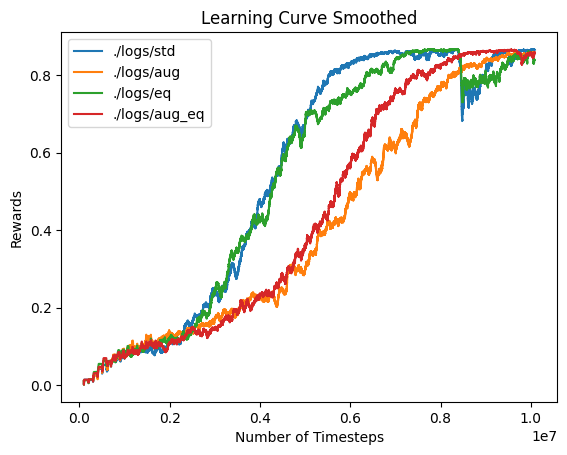

In [71]:
plot_results(['./logs/std', './logs/aug', './logs/eq', './logs/aug_eq'], title="Learning Curve")

## Visualizing Custom PPO Agent

In [79]:
# Visualize standard CNN agent behavior
std_frames = capture_frames_sb3(aug_agent, eval_180_env)
display(create_animation(std_frames))

# eq_frames = capture_frames_sb3(standard_agent, eval_270_env)
# display(create_animation(eq_frames))

Standard CNN PPO Architecture:
ActorCriticCnnPolicy(
  (features_extractor): MinigridFeaturesExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): MinigridFeaturesExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

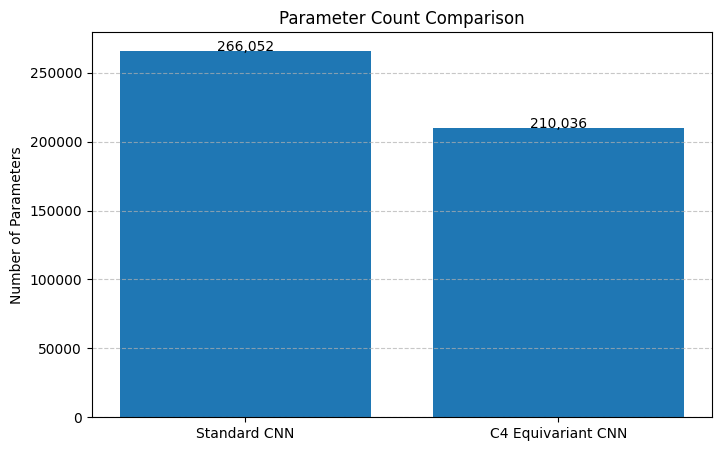

In [91]:
# Print model architectures
print("Standard CNN PPO Architecture:")
print(standard_agent.policy)
print("\nC4 Equivariant CNN PPO Architecture:")
print(equivariant_agent.policy)

# Compare parameter counts
std_params = count_parameters(standard_agent.policy)
eq_params = count_parameters(equivariant_agent.policy)
print(f"\nParameter Count Comparison:")
print(f"Standard CNN PPO: {std_params:,} parameters")
print(f"C4 Equivariant CNN PPO: {eq_params:,} parameters")

# Plot parameter comparison
labels = ['Standard CNN', 'C4 Equivariant CNN']
values = [std_params, eq_params]
plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title('Parameter Count Comparison')
plt.ylabel('Number of Parameters')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:,}", ha='center')
plt.show()

## 5. Testing Equivariance of Agents

In [89]:
def test_equivariance(agent, env, transform_fn, num_steps=5):
    obs, _ = env.reset()
    for step in range(num_steps):
        # Predict action on original observation
        action_original, _ = agent.predict(obs, deterministic=True)
        
        # Transform observation and predict action
        transformed_obs = transform_fn(obs)
        action_transformed, _ = agent.predict(transformed_obs, deterministic=True)
        
        print(f"Step {step}: Original Action={action_original}, Transformed Action={action_transformed}")
        
        # Check for equivariance
        if action_original != action_transformed:
            print(f"Equivariance failed at step {step}")
            return False
        
        # Take a step in the environment
        obs, reward, terminated, truncated, info = env.step(action_original)
        
        if terminated or truncated:
            print(f"Episode ended at step {step}")
            break
            
    print(f"Equivariance test passed for {num_steps} steps.")
    return True

# Example usage:
def rotate_observation_90(obs):
    # Ensure obs is a NumPy array and handle potential batch dimension
    if isinstance(obs, dict): # Handle Dict observation spaces if necessary
        # Assuming the image is under a key like 'image'
        img = obs['image']
        if img.ndim == 4: # Batch dimension present
             img = img.squeeze(0)
        rotated_img = np.rot90(img, k=1, axes=(0, 1)).copy()
        obs['image'] = rotated_img
        return obs
    else:
        if obs.ndim == 4: # Batch dimension present
             obs = obs.squeeze(0)
        return np.rot90(obs, k=1, axes=(0, 1)).copy()

is_equivariant = test_equivariance(equivariant_agent, eval_env, rotate_observation_90, num_steps=10)
print(f"\nIs the agent equivariant under 90-degree rotation? {is_equivariant}")

print("\nTesting standard agent (expected to fail):")
is_equivariant_std = test_equivariance(standard_agent, eval_env, rotate_observation_90, num_steps=10)
print(f"\nIs the standard agent equivariant under 90-degree rotation? {is_equivariant_std}")

Step 0: Original Action=2, Transformed Action=2
Step 1: Original Action=2, Transformed Action=0
Equivariance failed at step 1

Is the agent equivariant under 90-degree rotation? False

Testing standard agent (expected to fail):
Step 0: Original Action=2, Transformed Action=1
Equivariance failed at step 0

Is the standard agent equivariant under 90-degree rotation? False


# Generalization testing

In [61]:
%load_ext tensorboard
%tensorboard --logdir {TENSORBOARD_LOG_DIR}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15227), started 1:52:40 ago. (Use '!kill 15227' to kill it.)

In [ ]:
GEN_TIMESTEPS = 2e5
test_wrapper = Rotate180Wrapper#RandomRotateWrapper
test_degree = '180'
# test_180_270_wrapper_kwargs = {'full_obs': FULL_OBS, 'subset': [2,3]}
test_wrapper_kwargs = base_wrapper_kwargs#test_180_270_wrapper_kwargs
rot_test_std_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=test_wrapper,
                               wrapper_kwargs=test_wrapper_kwargs,
                               monitor_dir=f'./logs/rot_{test_degree}/std')
rot_test_eq_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=test_wrapper,
                               wrapper_kwargs=test_wrapper_kwargs,
                               monitor_dir=f'./logs/rot_{test_degree}/eq')
rot_test_aug_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=test_wrapper,
                               wrapper_kwargs=test_wrapper_kwargs,
                               monitor_dir=f'./logs/rot_{test_degree}/aug')
rot_test_aug_eq_vec_env = make_vec_env(ENV_NAME, n_envs=NUM_ENVS, seed=SEED,
                               wrapper_class=test_wrapper,
                               wrapper_kwargs=test_wrapper_kwargs,
                               monitor_dir=f'./logs/rot_{test_degree}/aug_eq')                               

In [60]:
new_standard_agent = make_ppo_agent(
    rot_test_std_vec_env, 
    use_equivariant_cnn=False,
    seed=SEED,
    config=standard_config,
    load='model_checkpoints/full/9x9_standard_agent_10m',
    tensorboard_log=TENSORBOARD_LOG_DIR + f"{test_degree}_standard"
)
print(f"Training standard CNN PPO for {GEN_TIMESTEPS} timesteps...")
new_standard_agent.learn(total_timesteps=int(GEN_TIMESTEPS), tb_log_name=f"{test_degree}_standard_run")
print("Standard CNN training completed!")

Loading model from model_checkpoints/full/9x9_standard_agent_10m
Wrapping the env in a VecTransposeImage.
Training standard CNN PPO for 200000.0 timesteps...
Logging to ./tensorboard_logs/180_270_standard/180_270_standard_run_1
-----------------------------
| time/              |      |
|    fps             | 3619 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 99.3      |
|    ep_rew_mean          | 0.00903   |
| time/                   |           |
|    fps                  | 1722      |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 2.4745262 |
|    clip_fraction        | 0.187     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.261    |
| 

In [53]:
new_eq_agent = make_ppo_agent(
    rot_test_eq_vec_env, 
    use_equivariant_cnn=True, 
    seed=1,
    config=equivariant_config,
    load='model_checkpoints/full/9x9_eq_agent_10m',
    tensorboard_log=TENSORBOARD_LOG_DIR + f"{test_degree}_eq"
)
print(f"Training Eq. CNN PPO for {GEN_TIMESTEPS} timesteps...")
new_eq_agent.learn(total_timesteps=int(GEN_TIMESTEPS), tb_log_name=f"{test_degree}_eq_run")
print("Eq. CNN training completed!")

Loading model from model_checkpoints/full/9x9_eq_agent_10m
Wrapping the env in a VecTransposeImage.
Training Eq. CNN PPO for 300000.0 timesteps...
Logging to ./tensorboard_logs/270_eq/270_eq_run_3
-----------------------------
| time/              |      |
|    fps             | 1746 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | 0          |
| time/                   |            |
|    fps                  | 999        |
|    iterations           | 2          |
|    time_elapsed         | 4          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.14937347 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_vari

In [51]:
new_aug_agent = make_ppo_agent(
    rot_test_aug_vec_env, 
    use_equivariant_cnn=False, 
    seed=SEED,
    config=standard_config,
    load='model_checkpoints/full/9x9_aug_agent_10m',
    tensorboard_log=TENSORBOARD_LOG_DIR + f"{test_degree}_aug"
)
print(f"Training aug CNN PPO for {GEN_TIMESTEPS} timesteps...")
new_aug_agent.learn(total_timesteps=int(GEN_TIMESTEPS), tb_log_name=f"{test_degree}_aug_run")
print("Aug CNN training completed!")

Loading model from model_checkpoints/full/9x9_aug_agent_10m
Wrapping the env in a VecTransposeImage.
Training aug CNN PPO for 300000.0 timesteps...
Logging to ./tensorboard_logs/270_aug/270_aug_run_1
-----------------------------
| time/              |      |
|    fps             | 3092 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 100       |
|    ep_rew_mean          | 0         |
| time/                   |           |
|    fps                  | 1639      |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0842725 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.143    |
|    explained_variance   | 0.

In [58]:
new_aug_eq_agent = make_ppo_agent(
    rot_test_aug_eq_vec_env, 
    use_equivariant_cnn=True, 
    seed=SEED,
    config=equivariant_config,
    load='model_checkpoints/full/9x9_aug_eq_agent_10m',
    tensorboard_log=TENSORBOARD_LOG_DIR + f"{test_degree}_aug_eq"
)
print(f"Training Aug eq CNN PPO for {GEN_TIMESTEPS} timesteps...")
new_aug_eq_agent.learn(total_timesteps=int(GEN_TIMESTEPS), tb_log_name=f"{test_degree}_aug_eq_run")
print("Aug eq CNN training completed!")

Loading model from model_checkpoints/full/9x9_aug_eq_agent_10m
Wrapping the env in a VecTransposeImage.
Training Aug eq CNN PPO for 200000.0 timesteps...
Logging to ./tensorboard_logs/180_aug_eq/180_aug_eq_run_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38       |
|    ep_rew_mean     | 0.658    |
| time/              |          |
|    fps             | 2670     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 98.1       |
|    ep_rew_mean          | 0.0206     |
| time/                   |            |
|    fps                  | 1158       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02209749

## Forgetting?